In [64]:
import os
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import models
from keras import backend as K
from keras.callbacks import TensorBoard, ModelCheckpoint
from tensorboard.plugins.hparams import api as hp
import tensorflow as tf
import tensorflow as tf
import numpy as np
import pickle
from datetime import datetime
from contextlib import redirect_stdout
import uuid
from matplotlib import pyplot as plt

In [43]:
L = 4
FEATURE_MAP_START = 16
EPOCHS = 32
# quick run of single param or full param sweep. Use True for testing.
QRUN = True
VERBOSE = False
# result dir in the tensorboardraw directory
BOARD_SUB_DIR = 'hp_autoencoder'

In [44]:
CHECKPOINTER = ModelCheckpoint(filepath='hparm_sweep_model_checkpoit.hdf5', 
                               monitor='val_loss',
                               verbose=1, 
                               save_best_only=True,
                               mode='auto')

In [45]:
if not QRUN:
    HP_BATCH_SIZE = hp.HParam('batch_size', hp.Discrete([15, 50]))
    HP_N_LAYERS = hp.HParam('n_layers', hp.Discrete([2, 3]))
    HP_FEATURE_MAP_STEP = hp.HParam('feature_map_step', hp.Discrete([2, 8, 16]))
    HP_STRIDE_SIZE = hp.HParam('stride', hp.Discrete([1, 2]))
else:
    HP_BATCH_SIZE = hp.HParam('batch_size', hp.Discrete([50]))
    HP_N_LAYERS = hp.HParam('n_layers', hp.Discrete([3]))
    HP_FEATURE_MAP_STEP = hp.HParam('feature_map_step', hp.Discrete([16]))
    HP_STRIDE_SIZE = hp.HParam('stride', hp.Discrete([1]))
    BOARD_SUB_DIR = 'qrun'

# Notes:
* Add `Input` argument `channels_first` when using Z3 data and 
  change the input dimensions.
* You will have to manualy add periodic edges for periodic padding before real runn
* **requires** running the transform notebook to get the data into a format for the auto encoder

In [46]:
with open('pickle_data.pkl', 'rb') as f:
    all_data = pickle.load(f)

all_data = all_data.astype('float32') / 5.0
n_records = len(all_data)
x_train = all_data[: n_records - int(n_records/4)]
x_test = all_data[int(n_records/4) :]
x_train = np.reshape(x_train, (len(x_train), L * 2, L * 2, 1))
x_test = np.reshape(x_test, (len(x_test), L * 2, L * 2, 1))

In [47]:
with tf.summary.create_file_writer(os.path.join('tensorboardraw', BOARD_SUB_DIR)).as_default():
    hp.hparams_config(
        hparams=[HP_BATCH_SIZE, HP_N_LAYERS, HP_FEATURE_MAP_STEP, HP_STRIDE_SIZE],
        metrics=[hp.Metric('binary_crossentropy', display_name='Loss')]
    )

In [52]:
def train_test_model(hparams):
    current_run_id = uuid.uuid4().hex
    
    input_obj = Input(shape=(L*2, L*2, 1))

    x = Conv2D(
        FEATURE_MAP_START,
        (3, 3),
        strides=hparams[HP_STRIDE_SIZE],
        activation='relu',
        padding='same',
        use_bias=True
    )(input_obj)

    for i in range(hparams[HP_N_LAYERS] - 1):
        fm = FEATURE_MAP_START + (i + 1) * hparams[HP_FEATURE_MAP_STEP]
        x = Conv2D(
            fm,
            (3, 3),
            strides=hparams[HP_STRIDE_SIZE],
            activation='relu',
            padding='same',
            use_bias=True
        )(x)
        
    max_fm = fm

    for i in range(hparams[HP_N_LAYERS] - 1):
        fm = max_fm - (i + 1) * hparams[HP_FEATURE_MAP_STEP]
        x = Conv2DTranspose(
            fm,
            (3, 3),
            strides=hparams[HP_STRIDE_SIZE],
            activation='relu',
            padding='same',
            use_bias=True
        )(x)
    
    decoded = Conv2DTranspose(
        1,
        (3, 3),
        strides=hparams[HP_STRIDE_SIZE],
        activation='relu',
        padding='same',
        use_bias=True
    )(x)

    autoencoder = Model(input_obj, decoded)
    #autoencoder.summary()
    autoencoder.compile(
        optimizer='adadelta',
        loss='binary_crossentropy',
        metrics=['binary_crossentropy']
    )

    #log_dir='tensorboardraw/hp_autoencoder/{}_{}'.format(datetime.now(), current_run_id)
    log_dir = os.path.join('tensorboardraw', BOARD_SUB_DIR)
    autoencoder.fit(
        x_train, x_train,
        epochs=EPOCHS,
        batch_size=hparams[HP_BATCH_SIZE],
        shuffle=True,
        validation_data=(x_test, x_test),
        callbacks=[
            TensorBoard(log_dir=log_dir),
            hp.KerasCallback(log_dir, hparams),
            CHECKPOINTER
        ]
    )
    _, binary_crossentropy = autoencoder.evaluate(x_test, x_test)
    return binary_crossentropy, autoencoder

In [55]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)
        loss, autoencoder = train_test_model(hparams)
        tf.summary.scalar('binary_crossentropy', loss, step=1)
        
    return autoencoder

In [56]:
c = 0
for batch_size in HP_BATCH_SIZE.domain.values:
    for n_layers in HP_N_LAYERS.domain.values:
        for f_map_step in HP_FEATURE_MAP_STEP.domain.values:
            for stride in HP_STRIDE_SIZE.domain.values:
                hparams = {
                    HP_BATCH_SIZE: batch_size,
                    HP_N_LAYERS: n_layers,
                    HP_FEATURE_MAP_STEP: f_map_step,
                    HP_STRIDE_SIZE: stride
                }
                c += 1
                run_name = "run-%d" % c
                print('--- Starting trial: %s' % run_name)
                print({h.name: hparams[h] for h in hparams})
                autoencoder = run(os.path.join('tensorboardraw', BOARD_SUB_DIR, run_name), hparams)

--- Starting trial: run-1
{'batch_size': 50, 'n_layers': 3, 'feature_map_step': 16, 'stride': 1}
Epoch 1/32
148/150 [============================>.] - ETA: 0s - loss: 3.0720 - binary_crossentropy: 3.0720
Epoch 00001: val_loss did not improve from 0.50532
150/150 [==============================] - 2s 12ms/step - loss: 3.0708 - binary_crossentropy: 3.0708 - val_loss: 2.9550 - val_binary_crossentropy: 2.9550
Epoch 2/32
147/150 [============================>.] - ETA: 0s - loss: 2.8641 - binary_crossentropy: 2.8641
Epoch 00002: val_loss did not improve from 0.50532
150/150 [==============================] - 2s 10ms/step - loss: 2.8622 - binary_crossentropy: 2.8622 - val_loss: 2.7635 - val_binary_crossentropy: 2.7635
Epoch 3/32
149/150 [============================>.] - ETA: 0s - loss: 2.6748 - binary_crossentropy: 2.6748
Epoch 00003: val_loss did not improve from 0.50532
150/150 [==============================] - 2s 10ms/step - loss: 2.6742 - binary_crossentropy: 2.6742 - val_loss: 2.5979 -

In [57]:
autoencoder.load_weights('hparm_sweep_model_checkpoit.hdf5')

In [58]:
autoencoder.save('models/best_hparam_autoencoder.h5')

In [59]:
layers_to_encoded = int(len(autoencoder.layers)/2)
print(layers_to_encoded)

3


In [60]:
layer_activations = [layer.output for layer in autoencoder.layers[:layers_to_encoded]]

In [61]:
activation_model = models.Model(
    inputs=autoencoder.input,
    outputs=layer_activations
)

In [62]:
x_test.shape

(7500, 8, 8, 1)

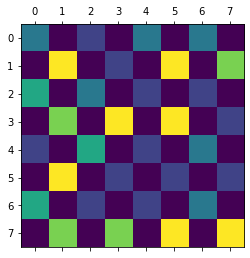

In [65]:
single_image = x_test[64]
plt.matshow(single_image[:, :, 0])

In [66]:
activations = activation_model.predict(x_test)

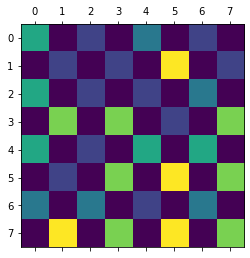

In [68]:
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[1, :, :, 0], cmap='viridis')

Layer_activation shape (7500, 8, 8, 16);    Layer name conv2d_126
Size 8;  N Features 16;  N Cols 1
Layer_activation shape (7500, 8, 8, 32);    Layer name conv2d_127
Size 8;  N Features 32;  N Cols 2


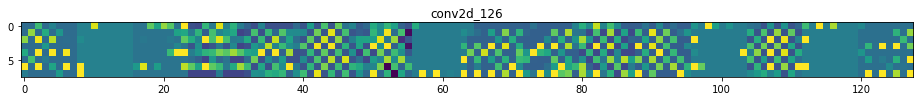

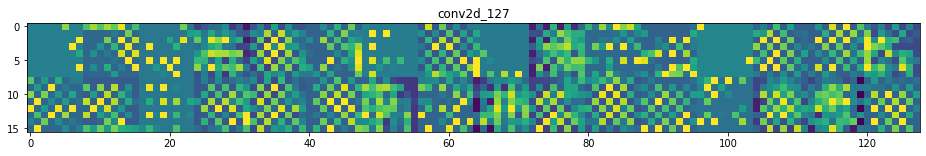

In [69]:
layer_names = []
for layer in autoencoder.layers[:layers_to_encoded]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

c = 0
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    if c == 0:
        c += 1
        continue
    print(f'Layer_activation shape {layer_activation.shape};    Layer name {layer_name}')
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = max([n_features // images_per_row, 1]) # Tiles the activation channels in this matrix
    print('Size {};  N Features {};  N Cols {}'.format(size, n_features, n_cols))
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            try:
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
            except IndexError:
                continue
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    c += 1